### NECESSARY IMPORTS

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
import tarfile
import shutil
import six.moves.urllib as urllib
from shutil import copyfile
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
#from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [3]:
cwd = os.getcwd()
dkube_dir_path=cwd

### WORKSPACE

In [4]:
# Directory for pets
directory = "pets_detection"
  
# Parent Directory path 
parent_dir = dkube_dir_path
  
# Path 
path = os.path.join(parent_dir, directory) 

os.mkdir(path) 
print("Directory '%s' created" %directory)

Directory 'pets_detection' created


In [5]:
base_path = dkube_dir_path+"/pets_detection"
annotations_path="/annotations"
data_path="data"
images_path="/images"
models_path="/models"

data_dir_path = os.path.join(base_path,data_path) 

os.mkdir(data_dir_path) 
print("Directory '%s' created" %data_path)

##### Creating the test-images and test-annotations folder ######
os.mkdir(base_path+images_path)
os.mkdir(base_path+models_path)
os.mkdir(base_path+annotations_path)
os.mkdir(base_path+images_path+"/test") 
os.mkdir(base_path+images_path+"/train")


Directory 'data' created


### DOWNLOADING THE DATASET

In [7]:
def download(data_dir):
    opener = urllib.request.URLopener()
    opener.retrieve("http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz",data_dir +"/annotations.tar.gz")
    opener.retrieve("http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", data_dir + "/images.tar.gz")
    print("Downloaded and saved the dataset. Location: ",data_dir)

In [8]:
download(data_dir_path)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  """Entry point for launching an IPython kernel.


Downloaded and saved the dataset. Location:  /home/ocdkube/workspace/pets_detection/data


### EXTRACTING THE DATASET

In [9]:
def extract(data_dir_path):
    print(data_dir_path)
    files = [os.path.join(data_dir_path, f) for f in os.listdir(data_dir_path) if f.endswith('tar.gz')]
    print(files)
    for filename in files:
        print(filename)
        tar = tarfile.open(filename)
        tar.extractall(data_dir_path)
        tar.close()
    print("Extracted objects and stored. Location: ",data_dir_path)

In [10]:
extract(data_dir_path)

/home/ocdkube/workspace/pets_detection/data
['/home/ocdkube/workspace/pets_detection/data/images.tar.gz', '/home/ocdkube/workspace/pets_detection/data/annotations.tar.gz']
/home/ocdkube/workspace/pets_detection/data/images.tar.gz
/home/ocdkube/workspace/pets_detection/data/annotations.tar.gz
Extracted objects and stored. Location:  /home/ocdkube/workspace/pets_detection/data


### DATA CLEANING

In [11]:
source=base_path+"/data/annotations/xmls/"
destination=base_path+"/data/images/"
for file in os.listdir(source):
    shutil.copy(source+file,destination)

In [12]:
xml_path=base_path+"/data/annotations/xmls/"
image_path=base_path+"/data/images/"
xml_list=[]
images_list=[]
for xml_file in os.listdir(xml_path):
    if xml_file.endswith('.xml'):
        xml_list.append(xml_file.strip('.xml'))

for image_file in os.listdir(image_path):
    if image_file.endswith('jpg'):
        images_list.append(image_file.strip('.jpg'))

In [13]:
len(xml_list)

3686

In [14]:
len(images_list)

7390

In [15]:
final_dataset_list=list(set(xml_list)& set(images_list))

In [16]:
len(final_dataset_list)

2986

In [17]:
os.mkdir(base_path+"/data/final_images")

In [18]:
source=base_path+"/data/images/"
destination=base_path+"/data/final_images/"
for file in os.listdir(source):
    file=file.strip('.jpg')
    if file in final_dataset_list:
        shutil.copy(source+file+'.jpg',destination)

In [19]:
! ls pets_detection/data/final_images/ | wc -l

2986


In [20]:
source=base_path+"/data/annotations/xmls/"
destination=base_path+"/data/final_images/"
for file in os.listdir(source):
    file=file.strip('.xml')
    if file in final_dataset_list:
        shutil.copy(source+file+'.xml',destination)

In [21]:
!ls pets_detection/data/final_images/ | wc -l

5972


### PARTITION THE DATASET INTO TRAIN AND TEST

In [22]:
import os
import re
from shutil import copyfile
import argparse
import math
import random


def iterate_dir(source, dest, ratio, copy_xml):
    source = source.replace('\\', '/')
    dest = dest.replace('\\', '/')
    train_dir = os.path.join(dest, 'train')
    test_dir = os.path.join(dest, 'test')

    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    images = [f for f in os.listdir(source)
              if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(.jpg|.jpeg|.png)$', f)]

    num_images = len(images)
    num_test_images = math.ceil(ratio*num_images)

    for i in range(num_test_images):
        idx = random.randint(0, len(images)-1)
        filename = images[idx]
        copyfile(os.path.join(source, filename),
                 os.path.join(test_dir, filename))
        if copy_xml:
            xml_filename = os.path.splitext(filename)[0]+'.xml'
            copyfile(os.path.join(source, xml_filename),
                     os.path.join(test_dir,xml_filename))
        images.remove(images[idx])

    for filename in images:
        copyfile(os.path.join(source, filename),
                 os.path.join(train_dir, filename))
        if copy_xml:
            xml_filename = os.path.splitext(filename)[0]+'.xml'
            copyfile(os.path.join(source, xml_filename),
                     os.path.join(train_dir, xml_filename))

In [23]:
iterate_dir(base_path+'/data/final_images', base_path+'/images', 0.1,'store_true')

In [25]:
shutil.copy(dkube_dir_path+'/label_map.pbtxt',base_path+'/annotations')

'/home/ocdkube/workspace/pets_detection/annotations/label_map.pbtxt'

### GENERATING TENSORFLOW RECORDS

In [26]:

!python generate_tfrecord.py -x pets_detection/images/train -l pets_detection/annotations/label_map.pbtxt -o pets_detection/annotations/train.record


Successfully created the TFRecord file: pets_detection/annotations/train.record


In [27]:

!python generate_tfrecord.py -x pets_detection/images/test -l pets_detection/annotations/label_map.pbtxt -o pets_detection/annotations/test.record


Successfully created the TFRecord file: pets_detection/annotations/test.record


### DOWNLOAD THE PRETRAINED MODEL

In [28]:
opener = urllib.request.URLopener()
opener.retrieve("http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz",base_path +"/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz")

('/home/ocdkube/workspace/pets_detection/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz',
 <http.client.HTTPMessage at 0x7f1847833048>)

In [29]:
tar = tarfile.open(base_path+'/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz')
tar.extractall(base_path)
tar.close()

In [30]:
os.mkdir(base_path+"/my_ssd_resnet50_v1_fpn")

In [31]:
shutil.copy(dkube_dir_path+'/pipeline.config',base_path+'/my_ssd_resnet50_v1_fpn/')

'/home/ocdkube/workspace/pets_detection/my_ssd_resnet50_v1_fpn/pipeline.config'

### TRAINING STARTS HERE

In [45]:

!python models/research/object_detection/model_main_tf2.py --model_dir=pets_detection/my_ssd_resnet50_v1_fpn --pipeline_config_path=pets_detection/my_ssd_resnet50_v1_fpn/pipeline.config


INFO:tensorflow:Initializing local devices since in-graph multi-worker training with `MirroredStrategy` is not supported in eager mode. TF_CONFIG will be ignored when when initializing `MirroredStrategy`.
I1021 07:50:48.517955 140484223432512 mirrored_strategy.py:302] Initializing local devices since in-graph multi-worker training with `MirroredStrategy` is not supported in eager mode. TF_CONFIG will be ignored when when initializing `MirroredStrategy`.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I1021 07:51:01.737304 140484223432512 mirrored_strategy.py:341] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I1021 07:51:01.841688 140484223432512 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1021 07:51:01.841911 140484223432512 config_util.py:552] Maybe overwriting use_bfloat16: 

### Exporting the Model

In [48]:

!python models/research/object_detection/exporter_main_v2.py --input_type image_tensor --pipeline_config_path pets_detection/my_ssd_resnet50_v1_fpn/pipeline.config --trained_checkpoint_dir pets_detection/my_ssd_resnet50_v1_fpn/ --output_directory pets_detection/models/exported-model


W1021 08:30:54.628834 140258716923712 save_impl.py:78] Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x7f901420b828>, because it is not built.
INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8d43224390>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8d43224400>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8d43224710>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], False), {}).
I1021 08:31:16.804573 140258716923712 def_function.py:1038] Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8d43224390>, TensorSpec(shape

### INFERENCE

In [8]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL =base_path+"/models/exported-model"+"/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 14.557690143585205 seconds


In [9]:
category_index = label_map_util.create_category_index_from_labelmap(base_path+"/annotations/label_map.pbtxt",use_display_name=True)


In [ ]:
### inference-images folder will contain images for which we want inference

In [7]:
os.mkdir(base_path+"/inference-images")

In [10]:
inference_image_folder=base_path+"/inference-images/"

Running inference for image1.jpg... Done


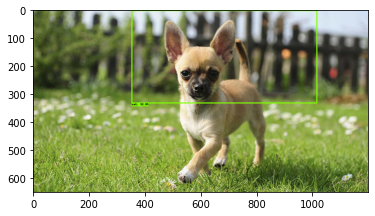

In [13]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


for image_path in os.listdir(inference_image_folder):

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(inference_image_folder+image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

# sphinx_gallery_thumbnail_number = 2